In [36]:
# -*- coding: utf-8 -*-
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import fftpack

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# データ ファイルのパス
PATH = 'Q4149CF2.csv'

In [38]:
# オリジナルの加速度を読み込む。
data = pd.read_csv(PATH, skiprows=6)
data = data.rename(columns={' NS': 'NS'})
print(data.head())
data.shape

    NS     EW     UD
0  0.0  0.001 -0.002
1  0.0  0.001 -0.000
2  0.0 -0.000 -0.000
3  0.0 -0.003 -0.001
4  0.0 -0.004 -0.002


(30000, 3)

Text(0.5,1,'UD')

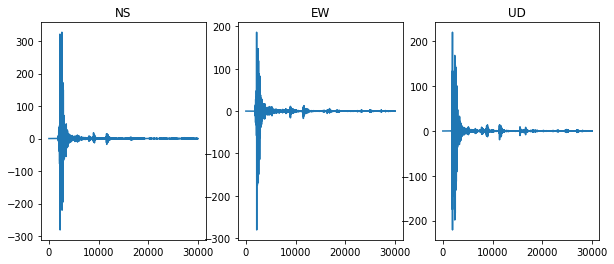

In [39]:
# オリジナルの加速度の波形を描画する。
fig, (ax_NS, ax_EW, ax_UD) = plt.subplots(ncols=3, figsize=(10,4))

ax_NS.plot(data['NS'])
ax_NS.set_title('NS')

ax_EW.plot(data['EW'])
ax_EW.set_title('EW')

ax_UD.plot(data['UD'])
ax_UD.set_title('UD')

In [40]:
# 1. データをフーリエ変換する。
fft_NS = pd.Series(fftpack.fft(data['NS']))
fft_EW = pd.Series(fftpack.fft(data['EW']))
fft_UD = pd.Series(fftpack.fft(data['UD']))
time_step = 1/100
print(f"NS: {fft_NS.size}, EW: {fft_EW.size}, UD: {fft_UD.size}")

# 周波数スケールの計算
freq_list = abs(fftpack.fftfreq(fft_NS.size, d=time_step))
pd.Series(freq_list)[:10]

NS: 30000, EW: 30000, UD: 30000


0    0.000000
1    0.003333
2    0.006667
3    0.010000
4    0.013333
5    0.016667
6    0.020000
7    0.023333
8    0.026667
9    0.030000
dtype: float64

/Users/yoshimutamasayuki/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'UD')

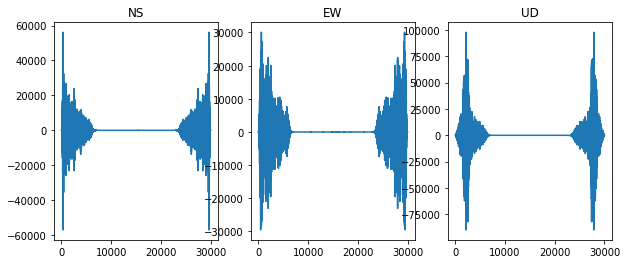

In [41]:
# オリジナルのスペクトル波形
fig, (ax_NS, ax_EW, ax_UD) = plt.subplots(ncols=3, figsize=(10,4))
fft_df = pd.concat([freq_list * fft_NS, freq_list * fft_EW, freq_list * fft_UD], axis=1)
fft_df = fft_df.rename(columns={0: 'NS', 1: 'EW', 2: 'UD'})

ax_NS.plot(fft_df['NS'])
ax_NS.set_title('NS')

ax_EW.plot(fft_df['EW'])
ax_EW.set_title('EW')

ax_UD.plot(fft_df['UD'])
ax_UD.set_title('UD')

In [42]:
# 2. フィルターをかける。(図3を参照)

# フィルターを準備
def filter_1(f):
    """周期の効果を表すフィルターです。
    """
    res = np.sqrt(1 / f[1:])
    return np.concatenate(([0]  ,res))


def filter_high(f):
    """ハイカットフィルターです。
    """
    y = f * 0.1
    result = (1 + 0.694 * (y ** 2) + 0.0557 * (y ** 6) + 0.009664 * (y ** 8)
              + 0.00134 *( y ** 10) + 0.000155 * (y ** 12))
    return 1 / np.sqrt(result)


def filter_low(f):
    """ローカットフィルターです。
    """
    return np.sqrt(1 - np.exp(- (f / 0.5) ** 3))


filtered_freq = filter_low(freq_list) * filter_high(freq_list) * filter_1(freq_list)
filtered_freq

array([0.        , 0.00942809, 0.01885617, ..., 0.0282842 , 0.01885617,
       0.00942809])

In [43]:
# フィルターをかける。

spec_NS = fft_NS * filtered_freq
spec_EW = fft_EW * filtered_freq
spec_UD = fft_UD * filtered_freq

In [44]:
# 3. 逆フーリエ変換する。

# 逆フーリエ変換する
resyn_NS = pd.Series(np.real(fftpack.ifft(spec_NS)))
resyn_EW = pd.Series(np.real(fftpack.ifft(spec_EW)))
resyn_UD = pd.Series(np.real(fftpack.ifft(spec_UD)))

# 逆フーリエ変換すると、虚部が残る可能性があるので、np.real をかぶせる。
ifft_df = pd.concat([resyn_NS, resyn_EW, resyn_UD], axis=1)

ifft_df = ifft_df.rename(columns={0: 'NS', 1: 'EW', 2: 'UD'})
ifft_df.head()

,NS,EW,UD
0,-0.054874,-0.017902,-0.017756
1,-0.037147,-0.014803,-0.007922
2,-0.026461,-0.012800,-0.002232
3,-0.020851,-0.011469,0.000070
4,-0.017576,-0.010328,0.001029


Text(0.5,1,'UD')

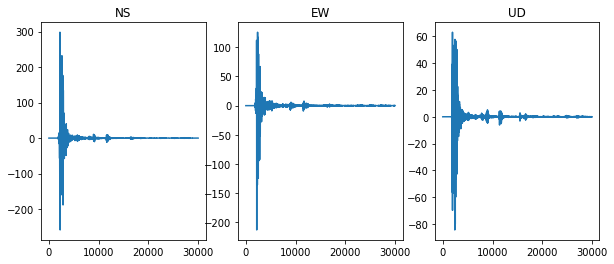

In [45]:
# フィルター補正後の加速度波形
fig, (ax_NS, ax_EW, ax_UD) = plt.subplots(ncols=3, figsize=(10,4))

ax_NS.plot(ifft_df['NS'])
ax_NS.set_title('NS')

ax_EW.plot(ifft_df['EW'])
ax_EW.set_title('EW')

ax_UD.plot(ifft_df['UD'])
ax_UD.set_title('UD')

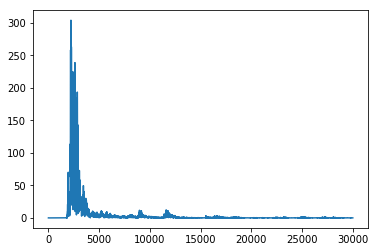

In [46]:
# 4. フィルター処理済みの3成分波形をベクトル的に合成する。

def synthesize_vector(x, y, z):
    return np.sqrt(x ** 2 + y ** 2 + z ** 2)

a = []
for row in ifft_df.iterrows():
    a.append(synthesize_vector(row[1]['NS'], row[1]['EW'], row[1]['UD']))

# ベクトル合成の結果
synthesized_series = pd.Series(a)

synthesized_series.plot()

In [47]:
# 5. a を求める。 
def get_a(syn_data):
    """ベクトル波形(フィルター処理済みの3成分波形をベクトル的に合成したもの)の絶対値がある値 a 以上となる時間の合計を計算したとき、
    これがちょうど 0.3秒となるような a を求めて、その a の値を返します。
    
    具体的には、デジタル記録のサンプリング時間間隔 dt としたとき、 
    ベクトル波形 p を絶対値の大きい順に並べて、 0.3 / dt 番目の値を
    a とする。
    
    サンプリング レートは 100Hz なのでサンプリング間隔は 0.01 sec.
    :param syn_data: 合成済みのデータ
    :type syn_data: pandas.Series
    :return: 条件を満たす a の値
    :rypte: float
    """
    dt = 1 / 100
    max_time = int(0.3 / dt)
    
    sorted_series = syn_data.sort_values(ascending=False).reset_index(drop=True)
    sorted_series.plot(use_index=False)
    return sorted_series[max_time]


a: 251.50770710750896


5.74

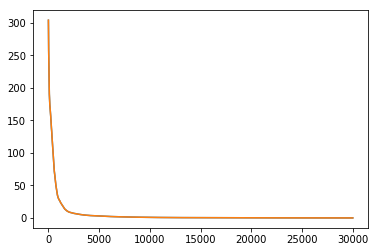

In [48]:
# 6. Iの小数第３位を四捨五入し、小数第２位を切り捨てたものを計測震度として返す。

from math import floor, log, log2, log10

# I を求めます.
def calc_intensity(a):
    a_real = np.real(a)
    res = round((2 * log10(a) + 0.94), 2)
    return res

print(f"a: {get_a(synthesized_series)}")
calc_intensity(get_a(synthesized_series))